# Customer Churn Prediction  
## Exploratory Data Analysis & Baseline Model

### Business Problem
Customer churn is costly. The goal of this project is to predict which customers are likely to churn and identify the key factors driving churn, enabling proactive retention strategies.

### Dataset
Telco Customer Churn dataset containing customer demographics, services, contract details, 
and billing information.

### Objective
- Perform exploratory data analysis (EDA)
- Identify churn drivers
- Build a baseline classification model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")

In [2]:
df = pd.read_excel("data/raw/Telco_customer_churn.xlsx")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
df.shape

(7043, 33)

In [4]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [5]:
df.isna().sum().sort_values(ascending=False).head(10)

Churn Reason         5174
Online Security         0
CLTV                    0
Churn Score             0
Churn Value             0
Churn Label             0
Total Charges           0
Monthly Charges         0
Payment Method          0
Paperless Billing       0
dtype: int64

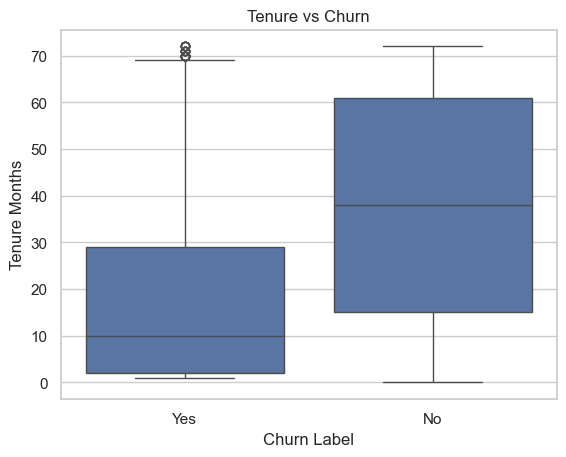

In [6]:
sns.boxplot(data=df, x="Churn Label", y="Tenure Months")
plt.title("Tenure vs Churn")
plt.show()

**Insight:**  
Customers who churn tend to have significantly shorter tenure compared to retained customers.  
This indicates that early-lifecycle customers are at the highest risk of churn and should be prioritized for retention efforts.

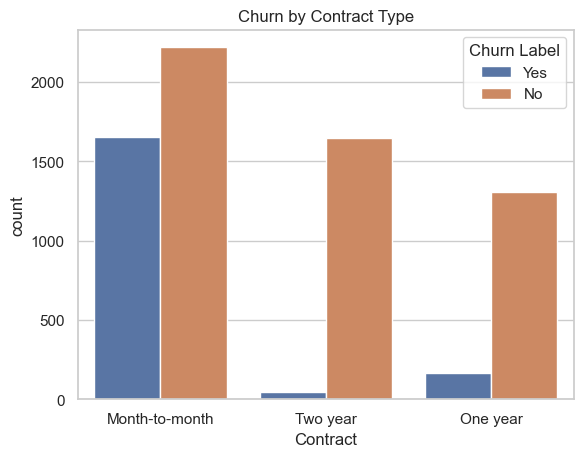

In [7]:
sns.countplot(data=df, x="Contract", hue="Churn Label")
plt.title("Churn by Contract Type")
plt.show()

**Insight:**  
Customers on month-to-month contracts exhibit significantly higher churn compared to those on one-year or two-year contracts.  
This suggests that increasing customer commitment through longer contract terms is a highly effective churn-reduction strategy.

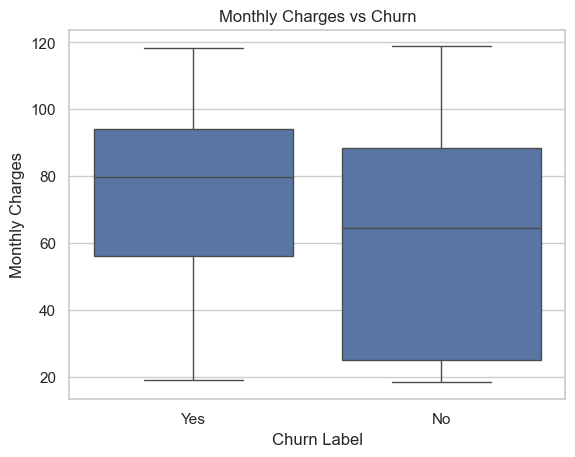

In [8]:
sns.boxplot(data=df, x="Churn Label", y="Monthly Charges")
plt.title("Monthly Charges vs Churn")
plt.show()

**Insight:**  
Customers who churn tend to have higher monthly charges compared to retained customers.  
This indicates that pricing pressure is a contributing factor to churn, particularly when customers do not perceive sufficient value relative to cost.

In [9]:
df["Churn Label"].value_counts(normalize=True)

Churn Label
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

**Class Balance:**  
Approximately 26.5% of customers have churned, while 73.5% have been retained.  
This indicates a moderately imbalanced dataset, meaning accuracy alone is not a sufficient evaluation metric and recall for churned customers will be particularly important.

In [10]:
y = df["Churn Label"].map({"Yes": 1, "No": 0})

In [11]:
drop_cols = [
    "CustomerID",
    "Churn Label",
    "Churn Reason",
    "Churn Score",
    "Churn Value",
    "CLTV",
    "Country",
    "State",
    "City",
    "Zip Code",
    "Lat Long"
]

X = df.drop(columns=drop_cols)

In [12]:
X = df.drop(columns=drop_cols)

In [13]:
X["Total Charges"] = pd.to_numeric(X["Total Charges"], errors="coerce")
X["Total Charges"] = X["Total Charges"].fillna(X["Total Charges"].median())

In [14]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

In [15]:
X_cat = pd.get_dummies(X[cat_cols], drop_first=True)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(X[num_cols]),
    columns=num_cols,
    index=X.index
)

In [17]:
X_processed = pd.concat([X_num, X_cat], axis=1)

In [18]:
X["Total Charges"].dtype

dtype('float64')

In [19]:
X_processed.shape

(7043, 33)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [21]:
X_train.shape, X_test.shape

((5634, 33), (1409, 33))

Baseline Logistic Regression Model

This baseline model uses standard logistic regression without class weighting.  
It provides a reference point for model performance, particularly overall accuracy and churn recall, before applying techniques to address class imbalance.

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=3000,
    solver="liblinear"
)

model.fit(X_train, y_train)

LogisticRegression(max_iter=3000, solver='liblinear')

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[917 118]
 [157 217]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.58      0.61       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



In [24]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)

,feature,coefficient
13,Internet Service_Fiber optic,0.830887
5,Total Charges,0.501842
31,Payment Method_Electronic check,0.368549
29,Paperless Billing_Yes,0.354535
12,Multiple Lines_Yes,0.320063
8,Partner_Yes,0.283236
24,Streaming TV_Yes,0.271205
26,Streaming Movies_Yes,0.241002
32,Payment Method_Mailed check,0.058642
7,Senior Citizen_Yes,0.022532


In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [27]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[916 119]
 [160 214]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.57      0.61       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



**Baseline Model Performance:**  
The logistic regression model achieves an accuracy of 80%, outperforming the baseline retention rate of 73.5%.  
Importantly, the model identifies approximately 57% of churned customers, demonstrating meaningful predictive power for early churn intervention.

In [31]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)

,feature,coefficient
13,Internet Service_Fiber optic,1.072407
5,Total Charges,0.495425
31,Payment Method_Electronic check,0.380706
12,Multiple Lines_Yes,0.368462
24,Streaming TV_Yes,0.367666
29,Paperless Billing_Yes,0.357251
26,Streaming Movies_Yes,0.337285
8,Partner_Yes,0.284795
32,Payment Method_Mailed check,0.073819
7,Senior Citizen_Yes,0.026151


Model Interpretation (Key Churn Drivers)

The logistic regression model identifies several factors strongly associated with customer churn. Customers subscribed to fiber-optic internet services exhibit the highest churn risk, likely due to higher pricing and elevated service expectations. Higher total charges further increase churn probability, indicating pricing pressure as a key driver. Payment via electronic check and enrollment in multiple or streaming services also correlate with increased churn, suggesting that customers with more complex or add-on plans may be more sensitive to perceived value. These findings highlight opportunities for targeted retention strategies focused on pricing transparency and service bundling.

Class-Weighted Logistic Regression (Final Model)

Because customer churn is a minority class and false negatives are costly, this model applies class weighting to prioritize the detection of at-risk customers.  
The goal is to improve churn recall while maintaining reasonable overall performance.

### Final Model Selection

Although the baseline logistic regression achieved higher overall accuracy, the class-weighted model significantly improved churn recall (from approximately 58% to 78%).  
Given the business cost of missed churners, the class-weighted logistic regression is selected as the final model recommendation.

In [32]:
from sklearn.linear_model import LogisticRegression

model_bal = LogisticRegression(
    max_iter=3000,
    solver="liblinear",
    class_weight="balanced"
)

model_bal.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, solver='liblinear')

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_bal = model_bal.predict(X_test)

print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))

[[756 279]
 [ 82 292]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [34]:
coef_bal_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model_bal.coef_[0]
}).sort_values("coefficient", ascending=False)

coef_bal_df.head(10)

,feature,coefficient
13,Internet Service_Fiber optic,0.972052
5,Total Charges,0.492432
31,Payment Method_Electronic check,0.392672
26,Streaming Movies_Yes,0.339770
24,Streaming TV_Yes,0.325066
29,Paperless Billing_Yes,0.318753
12,Multiple Lines_Yes,0.308289
8,Partner_Yes,0.274079
7,Senior Citizen_Yes,0.029024
32,Payment Method_Mailed check,0.027858


Improving Churn Detection via Class Weighting

To better address class imbalance and reduce missed churners, a class-weighted logistic regression model was trained. This adjustment increased churn recall from approximately 58% to 78%, enabling the model to identify a substantially higher proportion of at-risk customers. While overall accuracy decreased slightly, this tradeoff is appropriate for churn prevention scenarios, where the cost of failing to identify churners outweighs the cost of false positives. Importantly, the primary churn drivers remained consistent, reinforcing the robustness and interpretability of the model.
